##### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob 
from sklearn.model_selection import train_test_split

##### Load the dataset

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def construct_img(arr):
    return np.stack(np.split(arr, 3), axis=-1).reshape((32, 32, 3))
    
def unflatten_data(data):
    images = []
    for item in list(data):
        images.append(construct_img(item))
    return np.stack(images, axis=0)

In [3]:
data_batches = glob.glob('cifar-10-batches-py/data_batch_*')
data, labels = [], []

for batch in data_batches:
    data.append(unpickle(batch)[b'data'])
    labels.append(unpickle(batch)[b'labels'])

X_full_flattened = np.concatenate(data, axis=0)
X_full = unflatten_data(X_full_flattened)
y_full = np.concatenate(labels, axis=0)
X_test_flattened = unpickle('cifar-10-batches-py/test_batch')[b'data']
X_test = unflatten_data(X_test_flattened)
y_test = np.array(unpickle('cifar-10-batches-py/test_batch')[b'labels'])

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.7, random_state=42)

In [4]:
### Scale pixel values
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

##### Display sample images

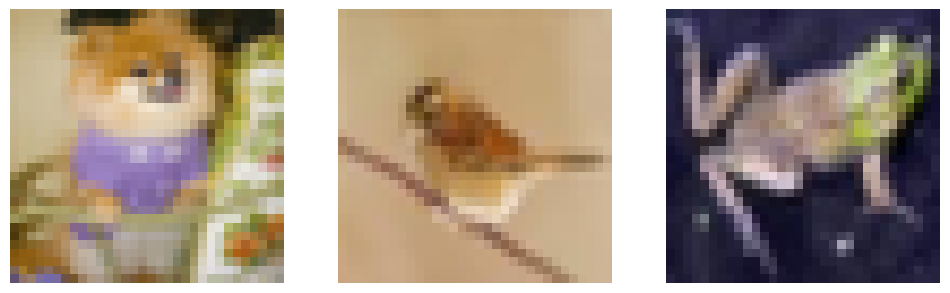

In [5]:
img_0 = X_train[45]
img_1 = X_train[3]
img_2 = X_train[267]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(img_0)
ax[1].imshow(img_1)
ax[2].imshow(img_2)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

##### Build the model

In [23]:
from keras.layers import Input, Dense, Lambda, Flatten, Conv2D, MaxPooling2D
from keras import Model

img_dim = (32, 32, 3)
kernel_size = (3, 3)
pool_size = (2, 2)

input_ = Input(shape=X_train.shape[1:], name='input_layer')
conv2d_1 = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', name='conv_layer_1')(input_)
pooling_1 = MaxPooling2D(pool_size=pool_size, name='pooling_payer_1')(conv2d_1)
conv2d_2 = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', name='conv_layer_2')(pooling_1)
pooling_2 = MaxPooling2D(pool_size=pool_size, name='pooling_layer_2')(conv2d_2)
flatten = Flatten(name='flatten_layer')(pooling_2)
dense = Dense(100, activation='relu', name='fully_connected_layer')(flatten)
output = Dense(10, activation='softmax', name='output_layer')(dense)
model = Model(inputs=[input_], outputs=[output])

In [24]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 30, 30, 32)        896       
                                                                 
 pooling_payer_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv_layer_2 (Conv2D)       (None, 13, 13, 64)        18496     
                                                                 
 pooling_layer_2 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_layer (Flatten)     (None, 2304)              0   